<a href="https://colab.research.google.com/github/claudiawulee/NLP_Emotional_Sentiment/blob/main/Emotional_Sentiment_NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Transformers installation
! pip install transformers datasets
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline 

from transformers import AutoTokenizer

dataset_name = 'emotion'
batch_size = 32

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 30.5 MB/s 
     |████████████████████████████████| 365 kB 65.3 MB/s 
     |████████████████████████████████| 6.6 MB 55.1 MB/s 
     |████████████████████████████████| 101 kB 14.5 MB/s 
     |████████████████████████████████| 596 kB 71.5 MB/s 
     |████████████████████████████████| 115 kB 76.8 MB/s 
     |████████████████████████████████| 141 kB 74.1 MB/s 
     |████████████████████████████████| 212 kB 74.3 MB/s 
     |████████████████████████████████| 127 kB 54.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#pre-processing data using colab tutorial notebook

def format_data(dataset_name, split_name):
  dataset = load_dataset(dataset_name, split = split_name) #raw dataset
  dataset.set_format('pandas')
  df = dataset[:]
  df.rename(columns = {'label' : 'labels'}, inplace = True)
  return Dataset.from_pandas(df)

  #print(df.head(5))
'''
splits = ['train', 'validation', 'test']
for split in splits: 
  format_data(dataset_name, split)
'''
'''
train = load_dataset("emotion", split = 'train')
validation = load_dataset("emotion", split = 'validation')
test = load_dataset("emotion", split = 'test')
'''

train = format_data(dataset_name, 'train')
validation = format_data(dataset_name, 'validation')
test = format_data(dataset_name, 'test')

train_size = len(train)
validation_size = len(validation)
test_size = len(test)
'''
print(train)
print(validation)
print(test)
'''
'''
print(train_size)
print(validation_size)
print(test_size)
'''

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)
Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


'\nprint(train_size)\nprint(validation_size)\nprint(test_size)\n'

In [ ]:
#tokenization 
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(dataset):
    return tokenizer(dataset["text"], truncation=True)

tokenized_train = train.map(tokenize_function, batched=True)
tokenized_validation = validation.map(tokenize_function, batched=True)
tokenized_test = test.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

print(tokenized_train)
print(tokenized_validation)
print(tokenized_test)

print(tokenized_validation[0])


  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16000
})
Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2000
})
Dataset({
    features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2000
})
{'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon', 'labels': 0, 'input_ids': [101, 10047, 3110, 3243, 6517, 1998, 3374, 2005, 2870, 2021, 5665, 10245, 2041, 1997, 2009, 2574, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
input_columns = ["attention_mask", "input_ids", "token_type_ids"]
label_column = ["labels"]

tf_train_dataset = tokenized_train.to_tf_dataset(
    columns=input_columns,
    label_cols=label_column,
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size,
)

tf_validation_dataset = tokenized_validation.to_tf_dataset(
    columns=input_columns,
    label_cols=label_column,
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size,
)

#print(tf_validation_dataset)
#print(tf_train_dataset)

# Load and Train Model

In [ ]:
num_labels = 6
checkpoint = "bert-base-uncased"
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_epochs = 6
steps_per_epoch = 50
sample_size = train_size
initial_learning_rate = 5e-5

#num_train_steps = (sample_size / float(batch_size)) * num_epochs 
num_train_steps = len(tf_train_dataset) * num_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer_function = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

model.compile(
    optimizer=optimizer_function,
    loss=loss_function,
    metrics=["accuracy"],
)
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
Total params: 109,486,854
Trainable params: 109,486,854
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(f"{dataset_name}, {checkpoint}, {batch_size}, {num_epochs}, {steps_per_epoch}, {initial_learning_rate}, {num_labels}")

history = model.fit(
    tf_train_dataset, 
    validation_data=tf_validation_dataset, 
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
)

emotion, bert-base-uncased, 32, 6, 50, 5e-05, 6
Epoch 1/6
50/50 [==============================] - 46s 555ms/step - loss: 1.4325 - accuracy: 0.4588 - val_loss: 1.0422 - val_accuracy: 0.6525
Epoch 2/6
50/50 [==============================] - 24s 483ms/step - loss: 0.8288 - accuracy: 0.7237 - val_loss: 0.5882 - val_accuracy: 0.8100
Epoch 3/6
50/50 [==============================] - 25s 498ms/step - loss: 0.4843 - accuracy: 0.8413 - val_loss: 0.3925 - val_accuracy: 0.8730
Epoch 4/6
50/50 [==============================] - 25s 504ms/step - loss: 0.3763 - accuracy: 0.8769 - val_loss: 0.2651 - val_accuracy: 0.9115
Epoch 5/6
50/50 [==============================] - 25s 499ms/step - loss: 0.2824 - accuracy: 0.9150 - val_loss: 0.2726 - val_accuracy: 0.9105
Epoch 6/6
50/50 [==============================] - 25s 503ms/step - loss: 0.2356 - accuracy: 0.9137 - val_loss: 0.2172 - val_accuracy: 0.9155


In [ ]:
print(f"{dataset_name}, {checkpoint}, {batch_size}, {num_epochs}, {steps_per_epoch}, {initial_learning_rate}, {history.history['accuracy'][-1]}, {history.history['val_accuracy'][-1]}")

emotion, bert-base-uncased, 32, 6, 50, 5e-05, 0.9137499928474426, 0.9154999852180481


<Figure size 432x288 with 0 Axes>

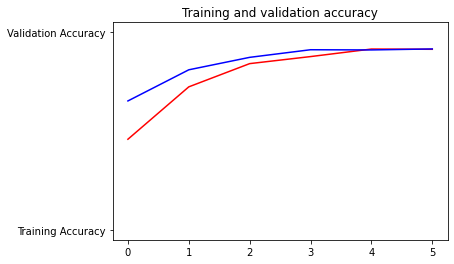

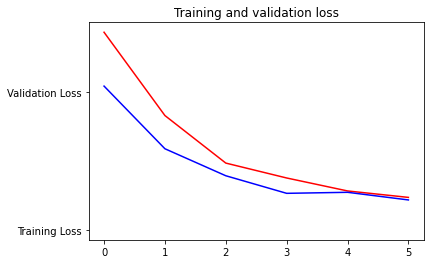

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [ ]:
from datasets import load_metric

tf_test_dataset = tokenized_test.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)
preds = model.predict(tf_test_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
print(preds.shape, class_preds.shape)

metric = load_metric("accuracy")
metric.compute(predictions=class_preds, references=tokenized_test["labels"])

(2000, 6) (2000,)


{'accuracy': 0.924}

In [ ]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from colorama import Fore, Style

def print_results(pred, actual):
  print(tokenized_test[i]["text"])
  print(Fore.GREEN if pred == actual else Fore.RED , end ="")
  if ('class_names' in globals()):
    print(f'predicted: {pred} ({class_names[pred]}), actual: {actual} ({class_names[actual]})')
  else:
    print(f'predicted: {pred}, actual: {actual}\n')
  print(Style.RESET_ALL, end ="")  
      
# examine errors
# for i in range(len(raw_datasets["test"])):
for i in range(10):
  pred = class_preds[i]
  actual = tokenized_test[i]["labels"]
  #if (pred != actual):
  print_results(pred, actual)

im feeling rather rotten so im not very ambitious right now
predicted: 0, actual: 0

im updating my blog because i feel shitty
predicted: 0, actual: 0

i never make her separate from me because i don t ever want her to feel like i m ashamed with her
predicted: 0, actual: 0

i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
predicted: 1, actual: 1

i was feeling a little vain when i did this one
predicted: 3, actual: 0

i cant walk into a shop anywhere where i do not feel uncomfortable
predicted: 4, actual: 4

i felt anger when at the end of a telephone call
predicted: 3, actual: 3

i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia
predicted: 1, actual: 1

i like to have the same breathless feeling as a reader eager to see what will happen next
predicted

In [ ]:
#created dataframe to store the actual vs predicted values 
lst = []
for i in range(len(tokenized_test)):
  pred = class_preds[i]
  actual = tokenized_test[i]["labels"]
  lst.append([pred, actual])
  #print(lst)
df_cm = pd.DataFrame(lst, columns = ['Predicted','Actual'])

#df_cm.head(50)


  #if (pred != actual):
    #print_results(pred, actual)

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(df_cm['Predicted'],df_cm['Actual'], labels = [0,1,2,3,4,5])

#print(cf_matrix)

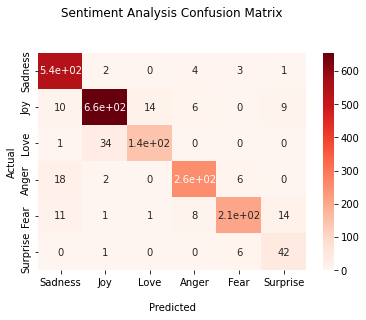

In [ ]:
#CM visual with heatmap

ax = sns.heatmap(cf_matrix, annot=True, cmap='Reds')

ax.set_title('Sentiment Analysis Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Sadness','Joy', 'Love', 'Anger', 'Fear', 'Surprise'])
ax.yaxis.set_ticklabels(['Sadness','Joy', 'Love', 'Anger', 'Fear', 'Surprise'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Saving Model

In [ ]:
#Saving
saved_path = "./my_tuned_model1"
model.save_pretrained(saved_path)

In [ ]:
#Reloading 
reloaded_model = model.from_pretrained(saved_path)

reloaded_preds = reloaded_model.predict(tf_test_dataset)["logits"]
reloaded_class_preds = np.argmax(reloaded_preds, axis=1)
print(reloaded_preds.shape, class_preds.shape)

metric = load_metric("accuracy")
metric.compute(predictions=reloaded_class_preds, references=tokenized_test["labels"])

NameError: ignored

# Ignore -Supervised Learning (using AI4ALL colab Notebook)

In [ ]:
df = pd.DataFrame(tokenized_train)
x_train = df[['input_ids']]
y_train = df[['labels']]

df2 = pd.DataFrame(tokenized_test)
x_test = df2[['input_ids']]
y_test = df2[['labels']]

In [ ]:
#KNN attempt
from sklearn.neighbors import KNeighborsClassifier

k_range = range(6)
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train.values.ravel())
    y_pred_knn = knn.predict(x_test)
    scores[k] = metrics.accuracy_score(y_test,y_pred_knn)
    scores_list.append(metrics.accuracy_score(y_test,y_pred_knn))
    
print('Accuracy:',scores_list)

ValueError: ignored

# Checking Data (Pre-Processing)

In [ ]:
#Pre-processing prior to colab notebook
split_name = 'test'
dataset = load_dataset(dataset_name, split = split_name)
dataset.set_format('pandas')
dataset[0]
df = dataset[:]
df.rename(columns = {'label' : 'labels'}, inplace = True)
#df.head()
#df['label'].value_counts()


def emotion_name(row):
  if row['labels'] == 0:
    return 'sadness'
  elif row['labels'] == 1:
    return 'joy'
  elif row['labels'] == 2:
    return 'love'
  elif row['labels'] == 3:
    return 'anger'
  elif row['labels'] ==4:
    return 'fear'
  elif row['labels'] == 5:
    return 'surprise'


df['emotion'] = df.apply(emotion_name, axis = 1)
#df[['label','emotion']].head()

#print(df)
df['emotion'].value_counts()

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: emotion, dtype: int64

In [ ]:
def find_str_length():
  return df['text'].str.len()

df["string length"] = find_str_length()
print(df)

                                                   text  labels  emotion  \
0     im feeling rather rotten so im not very ambiti...       0  sadness   
1             im updating my blog because i feel shitty       0  sadness   
2     i never make her separate from me because i do...       0  sadness   
3     i left with my bouquet of red and yellow tulip...       1      joy   
4       i was feeling a little vain when i did this one       0  sadness   
...                                                 ...     ...      ...   
1995  i just keep feeling like someone is being unki...       3    anger   
1996  im feeling a little cranky negative after this...       3    anger   
1997  i feel that i am useful to my people and that ...       1      joy   
1998  im feeling more comfortable with derby i feel ...       1      joy   
1999  i feel all weird when i have to meet w people ...       4     fear   

      string length  
0                59  
1                41  
2                97  

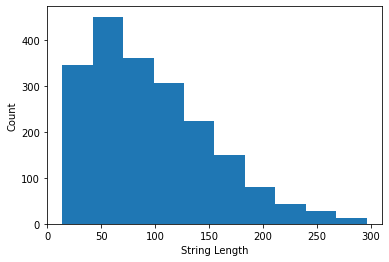

In [ ]:


plt.hist(df['string length'])
plt.xlabel('String Length') 
plt.ylabel('Count')
plt.show()

(array([1289.,  595.,  116.]),
 array([ 14., 108., 202., 296.]),
 <a list of 3 Patch objects>)

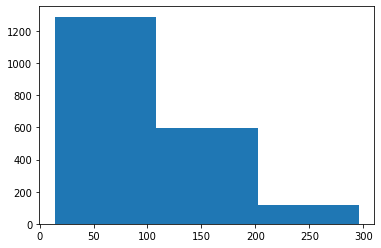

In [ ]:
plt.hist(df['string length'], bins = 3)

In [ ]:
def string_length_category(row):
  if row['string length'] <= 100:
    return 'short'
  elif row['string length'] >= 200:
    return 'long'
  else:
    return 'medium'

df['string length category'] = df.apply(string_length_category,axis=1)
print(df)

                                                   text  labels  emotion  \
0     im feeling rather rotten so im not very ambiti...       0  sadness   
1             im updating my blog because i feel shitty       0  sadness   
2     i never make her separate from me because i do...       0  sadness   
3     i left with my bouquet of red and yellow tulip...       1      joy   
4       i was feeling a little vain when i did this one       0  sadness   
...                                                 ...     ...      ...   
1995  i just keep feeling like someone is being unki...       3    anger   
1996  im feeling a little cranky negative after this...       3    anger   
1997  i feel that i am useful to my people and that ...       1      joy   
1998  im feeling more comfortable with derby i feel ...       1      joy   
1999  i feel all weird when i have to meet w people ...       4     fear   

      string length string length category  
0                59                  short

Text(0, 0.5, 'Count')

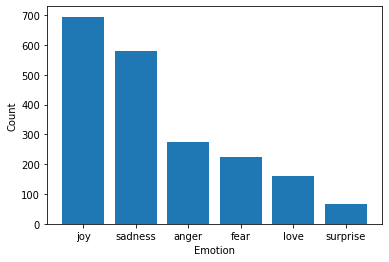

In [ ]:
fig, ax = plt.subplots() 
data = df['emotion'].value_counts() 
# get x and y data 
points = data.index 
frequency = data.values 
# create bar chart 
ax.bar(points, frequency) 
ax.set_xlabel('Emotion') 
ax.set_ylabel('Count')

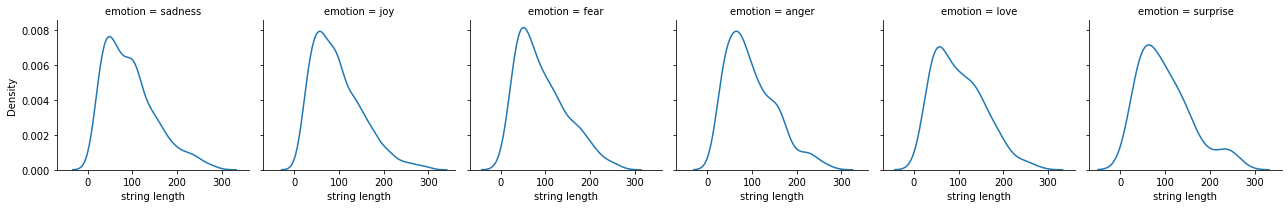

In [ ]:

g = sns.FacetGrid(df, col='emotion')
g = g.map(sns.kdeplot, 'string length')

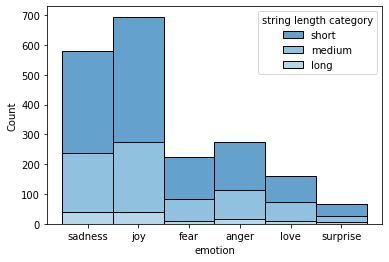

In [ ]:
ax = sns.histplot(df, x='emotion', hue='string length category',
             multiple='stack', palette='tab20c')